In [5]:
from __future__ import print_function

%matplotlib inline
import numpy
import matplotlib.pyplot as plt

# Solución de Problemas de Valores en la Frontera

## El Problema

Queremos resolver una EDO (EDP) que en lugar de tener condiciones iniciales está contenida en un intervalo y tiene valores en los bordes del intervalo. Esto surge de manera natural cuando consideramos problemas espaciales. Uno de los casos más simples de esto es el problema de Poisson en una dimensión
$$
    u_{xx} = f(x)
$$
donde usaremos la abreviatura
$$
    u_{xx} = \frac{\text{d}^2 u}{\text{d} x^2} \quad \text{o} \quad \frac{\partial^2 u}{\partial x^2}.
$$


Notemos que debido al orden de la derivada, requerimos dos condiciones para resolver esto. El caso más simple, donde estamos en el dominio $x \in [a,b]$, es tener condiciones tales que requerimos $u(a) = u_a$ y $u(b) = u_b$, y comúnmente se denominan problemas de valores en la frontera (BVP). Si estas condiciones están en un solo extremo del dominio, entonces en realidad podemos plantear nuevamente la EDO (EDP) como un problema de valor inicial (IVP). Entonces, ¿qué necesitamos hacer para resolver este tipo de problemas? Consideraremos dos enfoques para este problema:

1. Reformular el BVP como un IVP y utilizar nuestros métodos estándar para EDOs.
2. Usar diferencias finitas para representar las incógnitas como un sistema lineal y resolver el sistema resultante.

## El Método de Disparo

El método de disparo adopta el enfoque de que queremos usar nuestra capacidad para resolver problemas de valor inicial (IVP) y, por lo tanto, intenta plantear el problema como un problema de búsqueda de raíces para la condición inicial de mayor orden que no se nos ha dado. Esto se ilustra mejor con un ejemplo.

Consideremos el problema
$$
    u_{xx} = -\sin u
$$
con
$$
    x \in [0, 2] \quad \text{y} \quad u(0) = 0.0, \quad u(2.0) = \frac{\pi}{2}.
$$

Podemos reescribir este problema como un sistema de dos EDOs de la siguiente manera
$$
    v = \begin{bmatrix} u \\ u_x \end{bmatrix} \quad \text{y} \quad v_x = \begin{bmatrix} u_x \\ u_{xx} \end{bmatrix} = \begin{bmatrix} v_2 \\ -\sin v_1 \end{bmatrix}.
$$

Sabemos que queremos $v_1(0) = 0$, pero ¿qué usamos para $v_2(0)$? Haciendo una suposición inicial para $v_2(0)$ y resolviendo la EDO asociada al problema de valor inicial (IVP), podemos luego averiguar qué producen estas condiciones iniciales en el límite derecho del problema. Usando un enfoque de búsqueda de raíces (o una rutina de minimización), podemos escribir este procedimiento como
$$
    \min_{v_2(0)} \left | \pi / 2 - v_1(2) \right |
$$
donde el parámetro que variamos es $v_2(0)$.

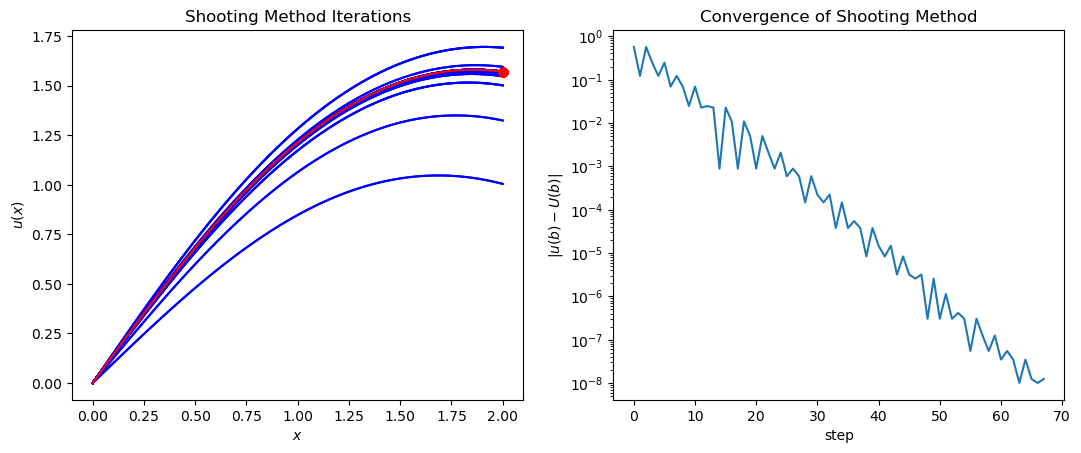

In [7]:
# Basic Shooting Method solving u_xx = -sin(u)
import scipy.integrate as integrate

# Algorithm parameters
TOLERANCE = 1e-8
MAX_ITERATIONS = 100

# Problem Statement
a = 0.0
b = 2.0
N = 100
x = numpy.linspace(a, b, N)
u_a = 0.0
u_b = numpy.pi / 2.0
# RHS function
def f(x, u):
    return numpy.array([u[1], -numpy.sin(u[0])])

# Initial guess
# Slope at RHS
u_prime_rhs = 1.0
# Initial step size
du_prime = 0.5

# Plotting
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
axes = fig.add_subplot(1, 2, 1)

# Main loop
success = False
u = numpy.empty((2, N))
convergence = numpy.zeros(MAX_ITERATIONS)
for n in range(MAX_ITERATIONS):
    
    # Initial condition
    u[0, 0] = u_a
    u[1, 0] = u_prime_rhs

    # Construct integrator
    integrator = integrate.ode(f)
    integrator.set_integrator("dopri5")
    integrator.set_initial_value(u[:, 0])

    # Compute solution - note that we are only producing the intermediate values
    # for demonstration purposes
    for (i, x_output) in enumerate(x[1:]):
        integrator.integrate(x_output)
        if not integrator.successful():
            raise Exception("Integration Failed!")
        u[:, i + 1] = integrator.y

    # Stopping Criteria
    convergence[n] = numpy.abs(u[0, -1] - u_b)
    if numpy.abs(u[0, -1] - u_b) < TOLERANCE:
        success = True
        break
    else:
        if u[0, -1] < u_b:
            u_prime_rhs += du_prime
        else:
            u_prime_rhs -= du_prime
            du_prime *= 0.5

    axes.plot(x, u[0, :], 'b')
    axes.plot(b, u_b, 'ro')

axes.plot(x, u[0, :], 'r')

axes.set_title("Shooting Method Iterations")
axes.set_xlabel("$x$")
axes.set_ylabel("$u(x)$")

axes = fig.add_subplot(1, 2, 2)
n_range = numpy.arange(n)
axes.semilogy(n_range, convergence[:n])
axes.set_title("Convergence of Shooting Method")
axes.set_xlabel("step")
axes.set_ylabel("$|u(b) - U(b)|$")

plt.show()

La parte complicada de este procedimiento es definir los criterios de búsqueda, es decir, decidir cómo cambiar $v_2(0)$ con respecto a la posición de $v_2(2)$ en comparación con lo que queremos para $u(2)$.

En general, cualquier rutina de minimización puede ser utilizada en un método de disparo. Estos enfoques son generalmente muy efectivos para resolver problemas de valor en la frontera no lineales (BVP), donde el próximo método que discutiremos resulta demasiado costoso de ejecutar.


## Enfoque del Sistema Lineal

### Formulación

El segundo enfoque que consideraremos involucra la formación de un sistema de ecuaciones para resolver basado en aproximaciones por diferencias finitas. Nuevamente, consideremos un ejemplo de problema donde
$$
    u_{xx} = f(x)
$$
con las condiciones iniciales $u(a) = u_a$ y $u(b) = u_b$.

Sabemos por nuestra discusión sobre diferencias finitas que la aproximación de diferencias centradas de segundo orden para la segunda derivada de una función $u(x)$ es
$$
    u_{xx} \approx \frac{u(x_{i-1}) - 2 u(x_i) + u(x_{i+1})}{\Delta x^2}.
$$

Si discretizamos el dominio del problema de valor en la frontera (BVP) en $N$ puntos (sin incluir los límites) tal que
$$
    x_i = a + \frac{b - a}{N+1} \cdot i \quad \text{donde} \quad i = 1, \ldots, N
$$
podemos entonces escribir la aproximación por diferencias finitas como un sistema de ecuaciones lineales.

Si, por ejemplo, tomamos $N = 5$, entonces
$$\begin{aligned}
    (U_{xx})_1 &\approx \frac{U_a - 2 U_1 + U_2}{\Delta x^2} \\
    (U_{xx})_2 &\approx \frac{U_1 - 2 U_2 + U_3}{\Delta x^2} \\
    (U_{xx})_3 &\approx \frac{U_2 - 2 U_3 + U_4}{\Delta x^2} \\
    (U_{xx})_4 &\approx \frac{U_3 - 2 U_4 + U_5}{\Delta x^2} \\
    (U_{xx})_5 &\approx \frac{U_4 - 2 U_5 + U_b}{\Delta x^2} \\
\end{aligned}$$
donde hemos utilizado $U_a = u(a)$ y $U_b = u(b)$ como las condiciones de frontera.

Usando estas aproximaciones para las derivadas, podemos escribir la EDO como
$$
    \frac{1}{\Delta x^2}\begin{bmatrix}
    -2 &  1 &    &    &    \\
     1 & -2 &  1 &    &    \\
       &  1 & -2 &  1 &    \\
       &    &  1 & -2 &  1 \\
       &    &    &  1 & -2 \\
    \end{bmatrix} \begin{bmatrix}
        U_1 \\ U_2 \\ U_3 \\ U_4 \\ U_5
    \end{bmatrix} = 
    \begin{bmatrix}
        f(x_1) \\ f(x_2) \\ f(x_3) \\ f(x_4) \\ f(x_5) \\
    \end{bmatrix}.
$$

Ten en cuenta que el ejemplo anterior utilizado para el método de disparo es complicado en el contexto actual, ya que la función desconocida está en la función $f$, por lo que necesitaríamos resolver un sistema de ecuaciones no lineales. Esto sigue siendo posible en este contexto utilizando un enfoque como un solucionador de Newton y tiene propiedades similares al método de disparo (aunque no es tan simple de implementar).

### Condiciones de Frontera Dirichlet 

Sin embargo, esto no incluye las condiciones de frontera. Podemos agregar fácilmente estos valores para condiciones de frontera de Dirichlet enviando los valores que conocemos al vector $b$:
$$\begin{aligned}
    \frac{U_a - 2 U_1 + U_2}{\Delta x^2} = f(x_1) &\Rightarrow& \frac{- 2 U_1 + U_2}{\Delta x^2} = f(x_1) - \frac{U_a}{\Delta x^2} \\
    \frac{U_4 - 2 U_5 + U_b}{\Delta x^2} = f(x_5) &\Rightarrow& \frac{U_4 - 2 U_5}{\Delta x^2} = f(x_5) - \frac{U_b}{\Delta x^2}
\end{aligned}$$
de modo que el sistema final luce como
$$
    \frac{1}{\Delta x^2} \begin{bmatrix}
    -2 &  1 &    &    &    \\
     1 & -2 &  1 &    &    \\
       &  1 & -2 &  1 &    \\
       &    &  1 & -2 &  1 \\
       &    &    &  1 & -2 \\
    \end{bmatrix} \begin{bmatrix}
        U_1 \\ U_2 \\ U_3 \\ U_4 \\ U_5
    \end{bmatrix} = 
    \begin{bmatrix}
        f(x_1) - \frac{U_a}{\Delta x^2} \\ f(x_2) \\ f(x_3) \\ f(x_4) \\ f(x_5) - \frac{U_b}{\Delta x^2} \\
    \end{bmatrix}.
$$

### Ejemplo

Queremos resolver el BVP
$$
    u_{xx} = e^x, \quad x \in [0, 1] \quad \text{con} \quad u(0) = 0.0, \text{ y } u(1) = 3
$$
a través de la construcción de un sistema lineal de ecuaciones.

\begin{align*}
    u_{xx} &= e^x \\
    u_x &= A + e^x \\
    u &= Ax + B + e^x\\
    u(0) &= B + 1 = 0 \Rightarrow B = -1 \\
    u(1) &= A - 1 + e^{1} = 3 \Rightarrow A = 4 - e\\ 
    ~\\
    u(x) &= (4 - e) x - 1 + e^x
\end{align*}

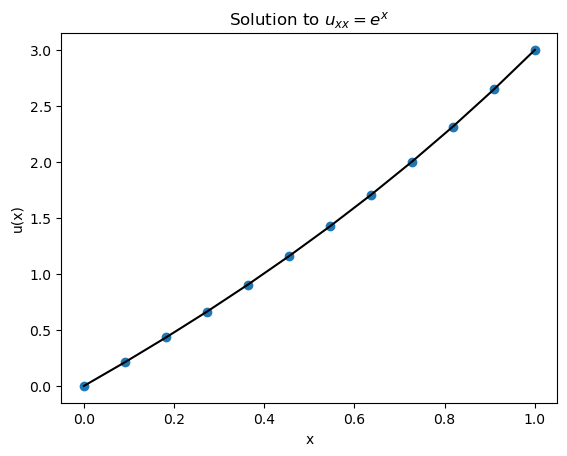

In [8]:
# Problem setup
a = 0.0
b = 1.0
u_a = 0.0
u_b = 3.0
f = lambda x: numpy.exp(x)
u_true = lambda x: (4.0 - numpy.exp(1.0)) * x - 1.0 + numpy.exp(x)

# Descretization
N = 10
x_bc = numpy.linspace(a, b, N + 2)
x = x_bc[1:-1]
delta_x = (b - a) / (N + 1)

# Construct matrix A
A = numpy.zeros((N, N))
diagonal = numpy.ones(N) / delta_x**2
A += numpy.diag(diagonal * -2.0, 0)
A += numpy.diag(diagonal[:-1], 1)
A += numpy.diag(diagonal[:-1], -1)

# Construct RHS
b = f(x)
b[0] -= u_a / delta_x**2
b[-1] -= u_b / delta_x**2

# Solve system
U = numpy.empty(N + 2)
U[0] = u_a
U[-1] = u_b
U[1:-1] = numpy.linalg.solve(A, b)

# Plot result
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(x_bc, U, 'o', label="Computed")
axes.plot(x_bc, u_true(x_bc), 'k', label="True")
axes.set_title("Solution to $u_{xx} = e^x$")
axes.set_xlabel("x")
axes.set_ylabel("u(x)")
plt.show()

### Condiciones de Frontera Neumann

Si en su lugar tenemos condiciones de frontera de Neumann, ya no está claro cómo manejar las condiciones de frontera utilizando el enfoque anterior. En su lugar, a menudo se utiliza un enfoque de **celdas fantasmas**. Estas **celdas fantasmas** son incógnitas adicionales que representan los valores de las fronteras que en realidad conocemos.

Por ejemplo, si tuviéramos el BVP
$$
    u_{xx} = e^x, \quad x \in [-1, 1] \quad \text{con} \quad u(-1) = 3, \text{ y } u_x(1) = -5
$$
entonces podríamos mantener los valores de frontera en el vector de incógnitas de modo que ahora
$$
    U = \begin{bmatrix} U_0 \\ U_1 \\ \vdots \\ U_N \\ U_{N+1} \end{bmatrix}
$$
donde $U_0$ y $U_{N+1}$ son en realidad los puntos de la frontera.

La matriz $A$ se modifica entonces para tener las relaciones apropiadas. En este caso, la condición de frontera izquierda conduce a
$$
    A = \begin{bmatrix}
  1 &    &    &    &    &    \\
  \frac{1}{\Delta x^2} & \frac{-2}{\Delta x^2} &  \frac{1}{\Delta x^2} &    &    &    \\
    &  \frac{1}{\Delta x^2} & \frac{-2}{\Delta x^2} &  \frac{1}{\Delta x^2} &    &    \\
    & & \ddots & \ddots & \ddots
    \end{bmatrix} \quad \text{y} \quad b = \begin{bmatrix}
        u(a) \\ f(x_1) \\ f(x_2) \\ \vdots
    \end{bmatrix}
$$
lo cual, al multiplicar, simplemente da
$$
    U_0 = u(-1) = 3.
$$

Para la condición de frontera derecha, podemos usar la aproximación de diferencias finitas hacia atrás de segundo orden para la primera derivada
$$
    u_x(b) \approx \frac{3 U_{N+1} - 4 U_{N} + U_{N - 1}}{2.0 \Delta x} = -5
$$
lo cual puede incorporarse en la matriz $A$ y el vector $b$ como
$$
    A =  \begin{bmatrix}
     \ddots & \ddots & \ddots &    &    \\
            & \frac{1}{\Delta x^2} &     \frac{-2}{\Delta x^2}&  \frac{1}{\Delta x^2} &    \\
            &        &      \frac{1}{\Delta x^2} & \frac{-2}{\Delta x^2} &  \frac{1}{\Delta x^2} \\
            &        &      \frac{1}{2 \Delta x} &  \frac{-4}{2 \Delta x} &  \frac{3}{2 \Delta x} \\
    \end{bmatrix} ~~~~ \text{y} ~~~~ b = \begin{bmatrix}
        \vdots \\ f(x_N) \\ u_x(b)
    \end{bmatrix}.
$$

En conjunto, el nuevo sistema luce como
$$
    \begin{bmatrix}
     1 &    &    &    &    &    \\
     \frac{1}{\Delta x^2} & \frac{-2}{\Delta x^2} &  \frac{1}{\Delta x^2} &    &    &    \\
       &  \ddots & \ddots &  \ddots &    \\
       &    & \frac{1}{\Delta x^2} & \frac{-2}{\Delta x^2} &  \frac{1}{\Delta x^2} \\
            &        &      \frac{1}{2 \Delta x} &  \frac{-4}{2 \Delta x} &  \frac{3}{2 \Delta x} \\
    \end{bmatrix} \begin{bmatrix}
        U_0 \\ U_1 \\ \vdots \\ U_N \\ U_{N+1}
    \end{bmatrix} = 
    \begin{bmatrix}
        u(a) \\ f(x_1) \\ \vdots \\ f(x_N) \\ u_x(b)
    \end{bmatrix}.
$$

### Ejemplo

Queremos resolver el BVP
$$
    u_{xx} = e^x, \quad x \in [-1, 1] \quad \text{con} \quad u(-1) = 3.0, \text{ y } u_x(1) = -5.0
$$
a través de la construcción de un sistema lineal de ecuaciones.

Primero, encuentra la solución exacta y luego calcula la solución.

\begin{align*}
    u(x) &= A x + B + e^x \\
    u_x(1) &= A + e^1 = -5 \Rightarrow A = -5 - e \\
    u(-1) &= (5 + e) + B + e^{-1} = 3 \Rightarrow B = 3 - 5 - e - e^{-1} = -(2 + e + e^{-1}) \\
    ~\\
    u(x) &= -(5 + e) x -(2 + e + e^{-1}) + e^{x}
\end{align*}

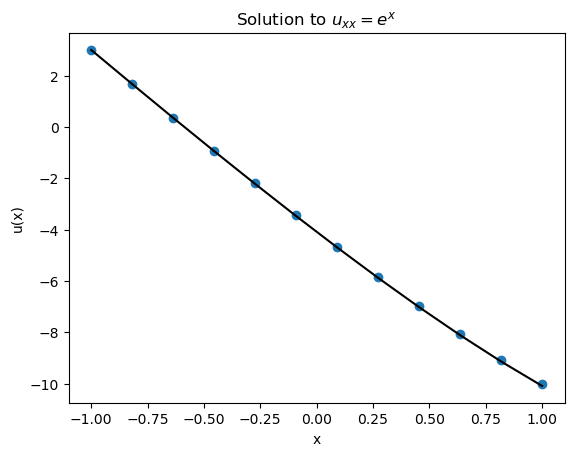

In [9]:
# Problem setup
a = -1.0
b = 1.0
u_a = 3.0
u_x_b = -5.0
f = lambda x: numpy.exp(x)
u_true = lambda x: -(5.0 + numpy.exp(1.0)) * x - (2.0 + numpy.exp(1.0) + numpy.exp(-1.0)) + numpy.exp(x)

# Descretization
N = 10
x_bc = numpy.linspace(a, b, N + 2)
x = x_bc[1:-1]
delta_x = (b - a) / (N + 1)

# Construct matrix A
A = numpy.zeros((N + 2, N + 2))
diagonal = numpy.ones(N + 2) / delta_x**2
A += numpy.diag(diagonal * -2.0, 0)
A += numpy.diag(diagonal[:-1], 1)
A += numpy.diag(diagonal[:-1], -1)

# Construct RHS
b = f(x_bc)

# Boundary conditions
A[0, 0] = 1.0
A[0, 1] = 0.0
A[-1, -1] = 3.0 / (2.0 * delta_x)
A[-1, -2] = -4.0 / (2.0 * delta_x)
A[-1, -3] = 1.0 / (2.0 * delta_x)

b[0] = u_a
b[-1] = u_x_b

# Solve system
U = numpy.empty(N + 2)
U = numpy.linalg.solve(A, b)

# Plot result
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(x_bc, U, 'o', label="Computed")
axes.plot(x_bc, u_true(x_bc), 'k', label="True")
axes.set_title("Solution to $u_{xx} = e^x$")
axes.set_xlabel("x")
axes.set_ylabel("u(x)")
plt.show()